In [1]:
!pip install -q spacy
!pip install -q tensorflow --upgrade
!pip install -q transformers

In [2]:
%env TF_CPP_MIN_LOG_LEVEL = 3

env: TF_CPP_MIN_LOG_LEVEL=3


In [3]:
import math
import nltk
import spacy
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import transformers
from tokenizers import BertWordPieceTokenizer
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras import Sequential
from keras.preprocessing.text import Tokenizer
from keras.metrics import Precision, Recall, AUC
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, LearningRateScheduler, CallbackList, ReduceLROnPlateau
from tensorflow.keras.optimizers.experimental import Adam

# **Loading Data**

In [4]:
from google.colab import drive

drive.mount('/content/drive')

import os

path = '/content/drive/MyDrive/Colab Notebooks/Cap7'

Mounted at /content/drive


In [5]:
train_data = pd.read_csv(os.path.join(path, 'dados_treino.txt'), header = None, delimiter = ';')

test_data = pd.read_csv(os.path.join(path, 'dados_teste.txt'), header = None, delimiter = ';')

In [6]:
train_data = train_data.rename(columns = {0: 'text', 1: 'sentiment'})
test_data = test_data.rename(columns = {0: 'text', 1: 'sentiment'})

In [7]:
train_data.shape

(16000, 2)

In [ ]:
test_data.shape

(2000, 2)

In [ ]:
train_data.head()

,text,sentiment
0,i am feeling completely overwhelmed i have two...,fear
1,i have the feeling she was amused and delighted,joy
2,i was able to help chai lifeline with your sup...,joy
3,i already feel like i fucked up though because...,anger
4,i still love my so and wish the best for him i...,sadness


In [ ]:
train_data['sentiment'].value_counts()

sentiment
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

In [ ]:
test_data['sentiment'].value_counts()

sentiment
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64

# **PreProcessing with Spacy**

In [8]:
# Download Dict
!python -m spacy download en_core_web_md -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 14.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [9]:
# Loading Dict
nlp_dict = spacy.load('en_core_web_md')

In [10]:
def preprocessing_text(text):
  # Processing text with Dict
  doc = nlp_dict(text)

  # Create an list with tokens
  tokens = [token.lemma_.lower().strip() for token in doc if not token.is_stop]

  # Return tokens
  return ' '.join(tokens)

In [11]:
train_data['Processed_text'] = train_data['text'].apply(preprocessing_text)

test_data['Processed_text'] = test_data['text'].apply(preprocessing_text)

In [ ]:
train_data.head()

,text,sentiment,Processed_text
0,i am feeling completely overwhelmed i have two...,fear,feel completely overwhelmed strategy help feel...
1,i have the feeling she was amused and delighted,joy,feeling amuse delight
2,i was able to help chai lifeline with your sup...,joy,able help chai lifeline support encouragement ...
3,i already feel like i fucked up though because...,anger,feel like fuck not usually eat morning
4,i still love my so and wish the best for him i...,sadness,love wish good long tolerate effect bm life fa...


In [12]:
# Function to encode text into int sequences for Bert model input
def encode(texts, tokenizer, chunk_size = 256, maxlen = 512):
  # Enable truncation in tokenizer to max lenght
  tokenizer.enable_truncation(max_length = maxlen)

  # Enable padding in tokenizer
  tokenizer.enable_padding(length = maxlen)

  all_ids = []

  # Iterate over all text in 'chunk pieces'
  for i in tqdm(range(0, len(texts), chunk_size)):
    text_chunk = texts[i:i+chunk_size].tolist()

    encs = tokenizer.encode_batch(text_chunk)

    # Extemded the list 'all_ids' with encoded Ids
    all_ids.extend(enc.ids for enc in encs)

  return np.array(all_ids)

In [ ]:
# Loading Tokenizer of pre-trained model
bert_tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

In [14]:
# Saving the tokenizer locally
bert_tokenizer.save_pretrained('.')

('./tokenizer_config.json',
 './special_tokens_map.json',
 './vocab.txt',
 './added_tokens.json')

In [15]:
# Loading a faster tokenizer using the core tokenizer vocabulary
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase = False)

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data['Processed_text'].values,
                                                      train_data['sentiment'].values,
                                                      test_size = 0.2,
                                                      random_state = 42,
                                                      stratify = train_data['sentiment'])

In [17]:
# Maximum length used in text
max_length = 100

In [18]:
# Apply tokenization
X_train_encoded = encode(X_train, fast_tokenizer, maxlen = max_length)
X_valid_encoded = encode(X_valid, fast_tokenizer, maxlen = max_length)
X_test_encoded = encode(test_data['Processed_text'], fast_tokenizer, maxlen = max_length)

100%|██████████| 8/8 [00:00<00:00, 103.85it/s]


In [19]:
label_encoder = LabelEncoder()

y_train_le = label_encoder.fit_transform(y_train)
y_valid_le = label_encoder.transform(y_valid)
y_test_le = label_encoder.transform(test_data['sentiment'])

y_train_encoded = to_categorical(y_train_le)
y_valid_encoded = to_categorical(y_valid_le)
y_test_encoded = to_categorical(y_test_le)

In [20]:
BATCH_SIZE = 16

In [21]:
train_dataset = (tf.data.Dataset
                 .from_tensor_slices((X_train_encoded, y_train_encoded))
                 .repeat()
                 .shuffle(2048)
                 .batch(BATCH_SIZE)
                 )

In [22]:
valid_dataset = (tf.data.Dataset
                 .from_tensor_slices((X_valid_encoded, y_valid_encoded))
                 .batch(BATCH_SIZE)
                 .cache()
                 )

In [23]:
test_dataset = (tf.data.Dataset
                .from_tensor_slices((X_test_encoded, y_test_encoded))
                .batch(BATCH_SIZE)
                )

# **Create Model**

In [37]:
# Function to apply fine-tune and train a transformer model (e.g. BERT)
def create_model(transformer, max_len = 512):

  # Define input layer
  input_word_ids = tf.keras.layers.Input(shape = (max_len,),
                                          dtype = tf.int32,
                                          name = 'input_word_ids')

  # Define sequence output of model
  sequence_output = transformer(input_word_ids)[0]

  # Select the first token of each sequence (token CLS in bert) for classification
  cls_token = sequence_output[:, 0, :]

  # Add a layer dense for classifcation
  out = Dense(6, activation = 'softmax')(cls_token)

  # Create keras model with input and output selected
  model = tf.keras.Model(inputs = input_word_ids, outputs = out)

  model.compile(tf.keras.optimizers.legacy.Adam(learning_rate = 1e-5),
                loss = 'categorical_crossentropy',
                metrics = ['accuracy', Precision(), Recall(), AUC()])

  return model


In [ ]:
#tokenizer = transformers.AutoTokenizer.from_pretrained("distilbert/distilbert-base-multilingual-cased")
# Create an instance of pretrained DistilBERT multilingual
transformer_layer = transformers.TFAutoModelForMaskedLM.from_pretrained("distilbert/distilbert-base-multilingual-cased")

In [ ]:
model = create_model(transformer_layer, max_len = max_length)

In [39]:
# Freezing pretained layers
model.layers[0].trainable = False
model.layers[1].trainable = False
model.layers[2].trainable = False

In [42]:
n_steps = X_train_encoded.shape[0] // BATCH_SIZE
num_epochs = 3

In [43]:
%%time
history = model.fit(train_dataset,
                    steps_per_epoch = n_steps,
                    validation_data = valid_dataset,
                    epochs = num_epochs)

Epoch 1/3
800/800 [==============================] - 423s 472ms/step - loss: 1.4004 - accuracy: 0.4768 - precision: 0.3940 - recall: 0.1491 - auc: 0.7019 - val_loss: 0.4905 - val_accuracy: 0.8341 - val_precision: 0.6684 - val_recall: 0.3657 - val_auc: 0.8340
Epoch 2/3
800/800 [==============================] - 372s 465ms/step - loss: 0.4382 - accuracy: 0.8518 - precision: 0.7591 - recall: 0.5173 - auc: 0.8969 - val_loss: 0.3629 - val_accuracy: 0.8834 - val_precision: 0.8064 - val_recall: 0.6122 - val_auc: 0.9305
Epoch 3/3
800/800 [==============================] - 383s 479ms/step - loss: 0.2857 - accuracy: 0.8953 - precision: 0.8292 - recall: 0.6652 - auc: 0.9465 - val_loss: 0.2979 - val_accuracy: 0.8975 - val_precision: 0.8469 - val_recall: 0.7058 - val_auc: 0.9578
CPU times: user 11min 53s, sys: 26.8 s, total: 12min 20s
Wall time: 20min 1s


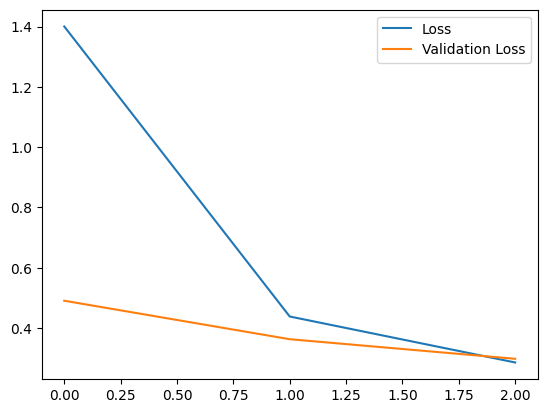

In [44]:
loss, val_loss = history.history['loss'], history.history['val_loss']
plt.plot(loss, label = 'Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend()
plt.show()

In [45]:
predict = model.predict(X_test_encoded)

63/63 [==============================] - 21s 269ms/step


In [46]:
predicted_labels = predict.argmax(axis = 1)

In [47]:
print(classification_report(y_test_le, predicted_labels))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89       275
           1       0.84      0.93      0.88       224
           2       0.91      0.92      0.91       695
           3       0.75      0.85      0.80       159
           4       0.96      0.89      0.92       581
           5       0.89      0.47      0.61        66

    accuracy                           0.89      2000
   macro avg       0.87      0.83      0.84      2000
weighted avg       0.90      0.89      0.89      2000



In [48]:
print(confusion_matrix(y_test_le, predicted_labels))

[[254   4   7   3   7   0]
 [  8 208   0   1   4   3]
 [  5   7 639  36   8   0]
 [  2   0  19 135   3   0]
 [ 24  11  24   5 516   1]
 [  2  18  13   0   2  31]]


In [49]:
print(accuracy_score(y_test_le, predicted_labels))

0.8915


In [53]:
model.save('/content/drive/MyDrive/Colab Notebooks/Cap7/model_v3.keras', save_format='tf')

ValueError: Unable to serialize VariableSpec(shape=(119547, 6), dtype=tf.float32, trainable=True, alias_id=None) to JSON, because the TypeSpec class <class 'tensorflow.python.ops.resource_variable_ops.VariableSpec'> has not been registered.

# **Deploy**

In [ ]:
# Loading Model
# Imports
from transformers import TFDistilBertModel
from tensorflow.keras.utils import custom_object_scope

# Register personalized layer and load the model
with custom_object_scope({'TFDistilBertModel': TFDistilBertModel}):
  loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Cap7/model_v3.keras')

In [ ]:
phrase = 'i even feel a little shaky'

In [ ]:
df = pd.DataFrame({'Phrase': [phrase]})

In [ ]:
df['Processed_phrase'] = df['Phrase'].apply(preprocessing_text)

In [ ]:
new_data = encode(df['Processed_phrase'], fast_tokenizer, max_len = max_length)

In [ ]:
result = loaded_model.predict(new_data)

In [ ]:
prob = np.argmax(result, axis = 1)

In [ ]:
name_cls = label_encoder.inverse_transform(prob)
name_cls

In [ ]:
%env TOKENIZERS_PARALLELISM = false